In [1]:
!gdown --id 1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1SqSn_8rxkk-Qvu4JLMcN_3ZFGDNa6P_V
To: /content/NonLinear_data.npy
100% 5.57k/5.57k [00:00<00:00, 10.3MB/s]


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_state = 59
np.random.seed(random_state)
torch.manual_seed(random_state)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_state)

In [6]:
data_path = '/content/NonLinear_data.npy'
data = np.load(data_path, allow_pickle = True).item()
X, y = data['X'], data ['labels']

In [8]:
print(X.shape, y.shape)

(300, 2) (300,)


In [60]:
val_size = 0.2
test_size = 0.125
is_shuffle = True

X_train , X_val , y_train , y_val = train_test_split (X, y,
                                                      test_size = val_size,
                                                      random_state = random_state,
                                                      shuffle = is_shuffle)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train,
                                                    test_size = test_size,
                                                    random_state = random_state,
                                                    shuffle = is_shuffle)

In [61]:
normalizer = StandardScaler()
X_train = normalizer.fit_transform(X_train)
X_val = normalizer.transform(X_val)
X_test = normalizer.transform(X_test)

X_train = torch.tensor(X_train, dtype = torch.float32)
X_val = torch.tensor(X_val, dtype = torch.float32)
X_test = torch.tensor(X_test, dtype = torch.float32)
y_train = torch.tensor(y_train, dtype = torch.long)
y_val = torch.tensor(y_val, dtype = torch.long)
y_test = torch.tensor(y_test, dtype = torch.long)

In [62]:
class CustomDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self) :
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [63]:
batch_size = 32
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [28]:
class MLP(nn.Module) :
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.linear1(x)
        x = F.relu(x)
        out = self.output(x)
        return out.squeeze(1)

In [41]:
class MLP(nn.Module) :
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.linear1(x)
        x = F.softmax(x)
        out = self.output(x)
        return out.squeeze(1)

In [53]:
class MLP(nn.Module) :
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.linear1(x)
        x = F.sigmoid(x)
        out = self.output(x)
        return out.squeeze(1)

In [64]:
class MLP(nn.Module) :
    def __init__(self, input_dims, hidden_dims, output_dims):
        super(MLP, self).__init__()
        self.linear1 = nn.Linear(input_dims, hidden_dims)
        self.output = nn.Linear(hidden_dims, output_dims)
        self.relu = nn.ReLU()

    def forward(self, x) :
        x = self.linear1(x)
        x = F.tanh(x)
        out = self.output(x)
        return out.squeeze(1)

In [70]:
input_dims = X_train.shape[1]
output_dims = torch.unique(y_train).shape[0]
hidden_dims = 512

model = MLP(input_dims = input_dims,
            hidden_dims = hidden_dims,
            output_dims = output_dims).to(device)

In [71]:
lr = 1e-1
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

In [72]:
def compute_accuracy(y_hat, y_true):
    _, y_hat = torch.max(y_hat, dim =1)
    correct = (y_hat == y_true).sum().item()
    accuracy = correct / len ( y_true )
    return accuracy

In [73]:
epochs = 100
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in range(epochs):
    train_loss = 0.0
    train_target = []
    train_predict = []

    model.train ()
    for X_samples, y_samples in train_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        optimizer.zero_grad()
        outputs = model(X_samples)
        loss = criterion(outputs, y_samples)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

        train_predict.append(outputs.detach().cpu())
        train_target.append(y_samples.cpu())

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    train_target = torch.cat(train_target)
    train_predict = torch.cat(train_predict)
    train_accs.append(compute_accuracy(train_predict, train_target))

    val_loss = 0.0
    val_target = []
    val_predict = []
    model.eval()
    with torch.no_grad():
        for X_samples, y_samples in val_loader :
            X_samples = X_samples.to(device)
            y_samples = y_samples.to(device)
            outputs = model(X_samples)
            val_predict.append(outputs.detach().cpu())
            val_target.append(y_samples.cpu())

            loss = criterion(outputs, y_samples)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)

    val_predict = torch.cat(val_predict)
    val_target = torch.cat(val_target)
    val_acc = compute_accuracy(val_predict, val_target)
    val_accs.append(val_acc)

    print(f'\nEPOCH {epoch + 1}:\tTraining loss : {train_loss :.3f}\tValidation loss : { val_loss :.3f}')


EPOCH 1:	Training loss : 0.841	Validation loss : 1.019

EPOCH 2:	Training loss : 0.811	Validation loss : 0.877

EPOCH 3:	Training loss : 0.882	Validation loss : 1.079

EPOCH 4:	Training loss : 0.730	Validation loss : 0.835

EPOCH 5:	Training loss : 0.774	Validation loss : 0.843

EPOCH 6:	Training loss : 0.789	Validation loss : 1.045

EPOCH 7:	Training loss : 0.735	Validation loss : 0.999

EPOCH 8:	Training loss : 0.792	Validation loss : 0.751

EPOCH 9:	Training loss : 0.844	Validation loss : 0.815

EPOCH 10:	Training loss : 0.675	Validation loss : 1.092

EPOCH 11:	Training loss : 0.816	Validation loss : 0.776

EPOCH 12:	Training loss : 0.733	Validation loss : 0.920

EPOCH 13:	Training loss : 0.726	Validation loss : 0.856

EPOCH 14:	Training loss : 0.680	Validation loss : 0.840

EPOCH 15:	Training loss : 0.716	Validation loss : 0.704

EPOCH 16:	Training loss : 0.578	Validation loss : 0.634

EPOCH 17:	Training loss : 0.606	Validation loss : 0.950

EPOCH 18:	Training loss : 0.671	Validat

In [74]:
test_target = []
test_predict = []
model.eval()
with torch.no_grad():
    for X_samples, y_samples in test_loader:
        X_samples = X_samples.to(device)
        y_samples = y_samples.to(device)
        outputs = model(X_samples)

        test_predict.append(outputs.cpu())
        test_target.append(y_samples.cpu())

    test_predict = torch.cat(test_predict)
    test_target = torch.cat(test_target)
    test_acc = compute_accuracy(test_predict, test_target)

    print('Evaluation on test set :')
    print(f'Accuracy : { test_acc }')

Evaluation on test set :
Accuracy : 0.9


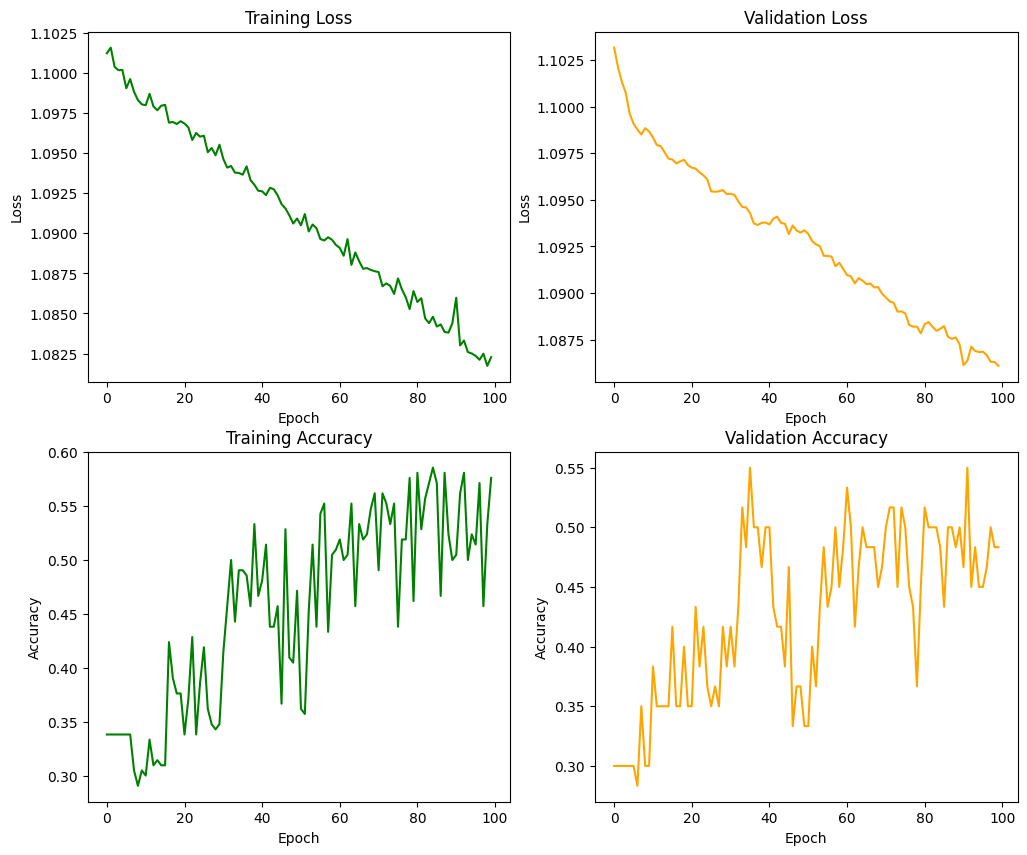

In [47]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10))
ax[0, 0].plot(train_losses, color='green')
ax[0, 0].set(xlabel='Epoch', ylabel ='Loss')
ax[0, 0].set_title('Training Loss')

ax[0, 1].plot(val_losses, color='orange')
ax[0, 1].set(xlabel='Epoch', ylabel='Loss')
ax[0, 1].set_title('Validation Loss')

ax[1, 0].plot(train_accs, color='green')
ax[1, 0].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 0].set_title('Training Accuracy')

ax[1, 1].plot(val_accs, color='orange')
ax[1, 1].set(xlabel='Epoch', ylabel='Accuracy')
ax[1, 1].set_title('Validation Accuracy')

plt.show()